In [216]:
import tifffile
import numpy as np
from skimage.color import rgb2hed, hed2rgb, rgb2gray
from skimage import filters, morphology, measure, segmentation, color, feature
from skimage.io import imread, imshow
from skimage.segmentation import watershed, find_boundaries
from skimage.feature import peak_local_max
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.util import crop
import pandas as pd
from skimage.draw import polygon
import cv2
from skimage.registration import phase_cross_correlation
from skimage.transform import warp, AffineTransform
from skimage.morphology import white_tophat
from matplotlib.colors import ListedColormap
import scanpy as sc
import anndata
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# Load data

In [2]:
cod_path = "./data/D016-RLL-11B2-6_Scan3.qptiff"

In [3]:
# DAPI
with tifffile.TiffFile(cod_path) as tif:
     dapi = tif.pages[0].asarray()

In [4]:
print(dapi.shape)

(48240, 30720)


In [5]:
his_path = "./data/D016-RLL-11B2-6_Scan1.qptiff"

In [6]:
# with tifffile.TiffFile(his_path) as tif:
#     he = tif.pages[0].asarray()

In [6]:
he = imread(his_path)

In [7]:
print(he.shape)

(48960, 32640, 3)


In [8]:
# padding dapi to he size
small_height, small_width = dapi.shape
big_height, big_width, _ = he.shape

top_pad = (big_height - small_height) // 2
bottom_pad = big_height - small_height - top_pad
left_pad = (big_width - small_width) // 2
right_pad = big_width - small_width - left_pad

# Apply padding to the small image
dapi = cv2.copyMakeBorder(dapi, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
print(dapi.shape)

(48960, 32640)


In [11]:
# extract H channel
hed = rgb2hed(he)
h = hed[:,:,0].astype()

In [17]:
# rescale to int8 (0,255)
h_rescale = rescale_intensity(h,in_range = 'image', out_range=(0,255))

In [18]:
if h_rescale.dtype != 'uint8':
    h_rescale = cv2.convertScaleAbs(h_rescale)
    
if dapi.dtype != 'uint8':
    dapi = cv2.convertScaleAbs(dapi)

# Registration

## Step1: coarse registration

In [19]:
# resize
resize_factor = 1/10

In [20]:
h_rs = cv2.resize(h_rescale, (0,0),fx = resize_factor, fy = resize_factor)
dapi_rs = cv2.resize(dapi, (0,0),fx = resize_factor, fy = resize_factor)

In [21]:
print(h_rs.shape,dapi_rs.shape)

(4896, 3264) (4896, 3264)


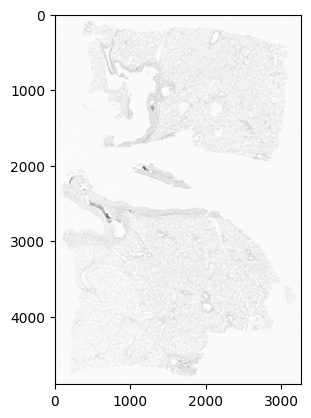

In [22]:
plt.imshow(255-h_rs,cmap='gray')
plt.show()

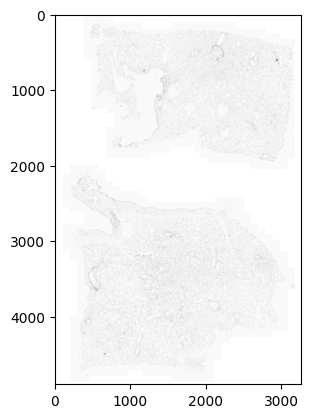

In [23]:
plt.imshow(255-dapi_rs,cmap='gray')
plt.show()

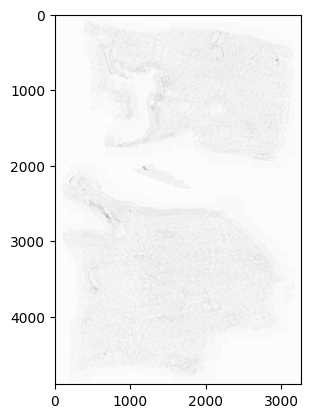

In [24]:
plt.imshow(255-h_rs,cmap='gray',alpha=1)
plt.imshow(255-dapi_rs,cmap='gray',alpha=0.6)
plt.show()

In [25]:
shift, error, diffphase = phase_cross_correlation(h_rs, dapi_rs, upsample_factor=2) 

In [26]:
shift_transform = AffineTransform(translation=(shift[1], shift[0]))

In [27]:
h_rs_reg = warp(h_rs, shift_transform, mode='constant', cval=0)

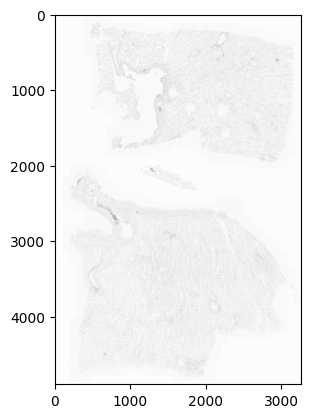

In [28]:
plt.imshow(255-h_rs_reg,cmap='gray',alpha=1)
plt.imshow(255-dapi_rs,cmap='gray',alpha=0.6)
plt.show()

### check coarse registration result

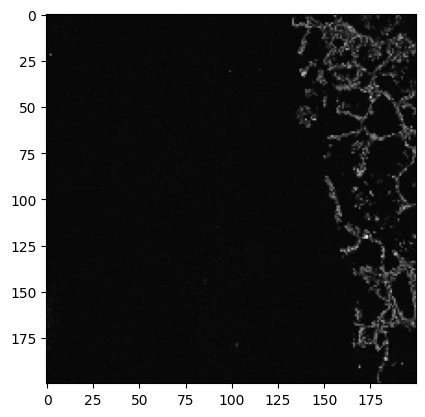

In [29]:
plt.imshow(h_rs_reg[500:700,400:600],cmap='gray')

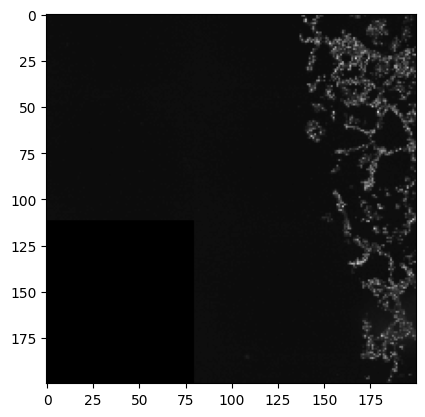

In [30]:
plt.imshow(dapi_rs[500:700,400:600],cmap='gray')

### coarse registration original image

In [31]:
## get affine transform for original image
scale_matrix = np.array([[1, 0, 1/resize_factor],
                         [0, 1, 1/resize_factor],
                         [0, 0, 1]])

In [32]:
mapped_shift_transform = shift_transform.params*scale_matrix

In [33]:
h_reg = warp(h_rescale, mapped_shift_transform, mode='constant', cval=0)

In [34]:
print(h_reg.shape)

(48960, 32640)


## Step2: fine registration

In [35]:
# reference region
min_x = 5000
max_x = 6000
min_y = 5500
max_y = 6500

In [36]:
ref_h = h_reg[min_x:max_x,min_y:max_y]

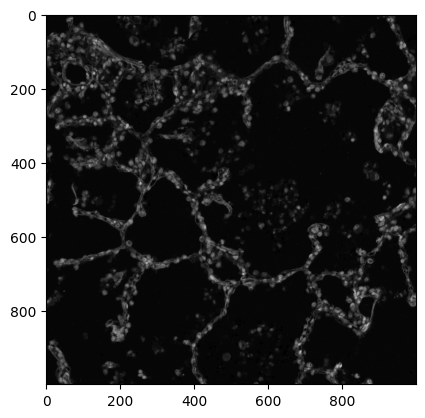

In [37]:
plt.imshow(ref_h,cmap='gray')

In [38]:
ref_dapi = dapi[min_x:max_x,min_y:max_y]

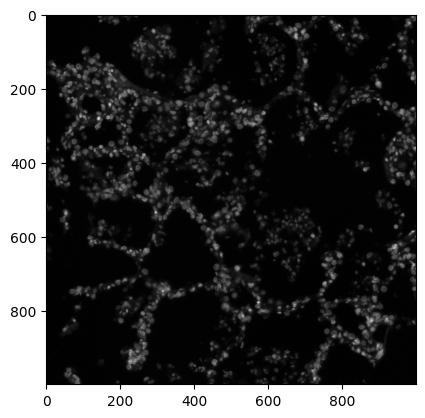

In [39]:
plt.imshow(ref_dapi,cmap='gray')

In [40]:
shift2, error2, diffphase2 = phase_cross_correlation(ref_h, ref_dapi) 

In [41]:
shift_transform2 = AffineTransform(translation=(shift2[1], shift2[0]))

In [42]:
ref_h_reg = warp(ref_h, shift_transform2, mode='constant', cval=0)

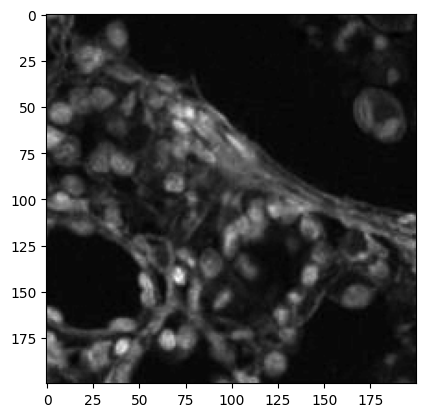

In [323]:
plt.imshow(ref_h_reg[100:300,100:300],cmap='gray')

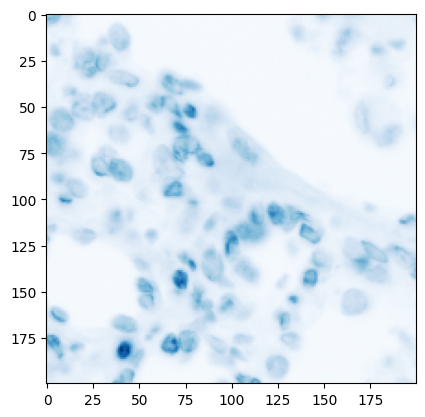

In [326]:
plt.imshow(ref_dapi[100:300,100:300],cmap='Blues',alpha=1)

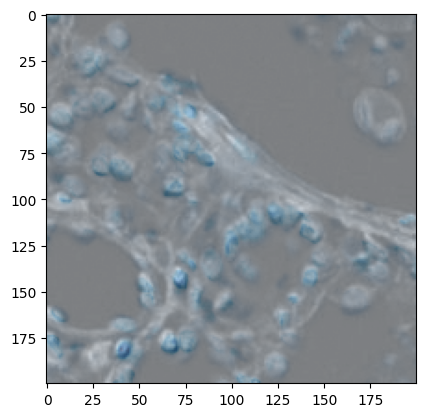

In [330]:
plt.imshow(ref_h_reg[100:300,100:300],cmap='gray')
plt.imshow(ref_dapi[100:300,100:300],cmap='Blues',alpha=0.5)
plt.show()

## Step3: final shift_transform

In [53]:
final_shift_transform = mapped_shift_transform+shift_transform2-np.eye(3)

In [54]:
np.save('shift_transform.npy',final_shift_transform)

# ROI

In [55]:
# roi
min_x = 5000
max_x = 6000
min_y = 5500
max_y = 6500

In [56]:
roi_dapi = dapi[min_x:max_x,min_y:max_y]

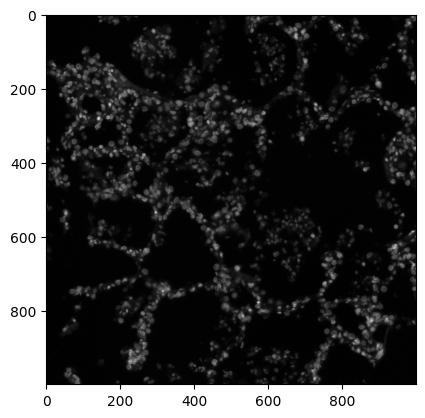

In [57]:
plt.imshow(roi_dapi,cmap='gray')

In [61]:
# HE
final_shift_transform = np.load('shift_transform.npy')

In [62]:
he_reg = warp(he, final_shift_transform, mode='constant', cval=0,preserve_range=True)

In [63]:
roi_he = he_reg[min_x:max_x,min_y:max_y].astype(np.uint8)

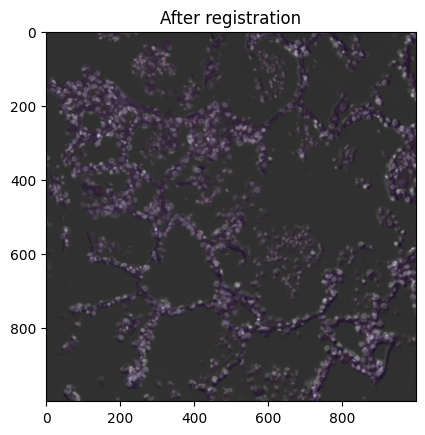

In [68]:
plt.imshow(roi_dapi,cmap='gray')
plt.imshow(roi_he,alpha=0.2)
plt.title('After registration')
plt.show()

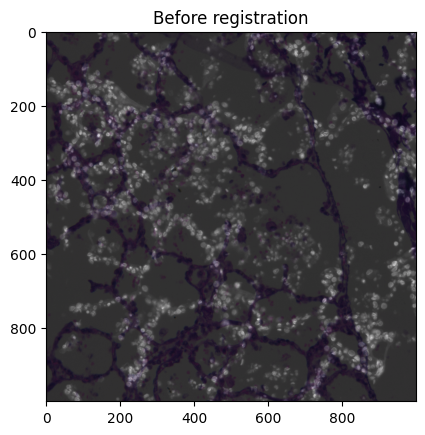

In [70]:
plt.imshow(roi_dapi,cmap='gray')
plt.imshow(he[min_x:max_x,min_y:max_y].astype(np.uint8),alpha=0.2)
plt.title('Before registration')
plt.show()

# Nuclei Segmentation

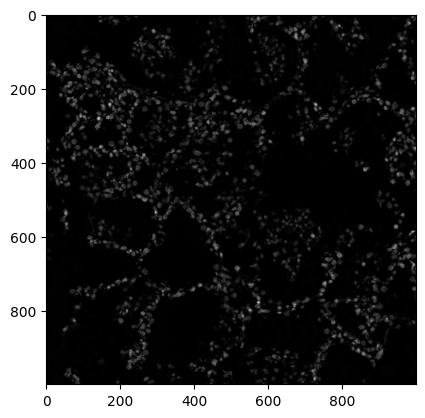

In [71]:
# tophat
tophat_image = white_tophat(roi_dapi, footprint=np.ones((13, 13)))
plt.imshow(tophat_image,cmap='gray')

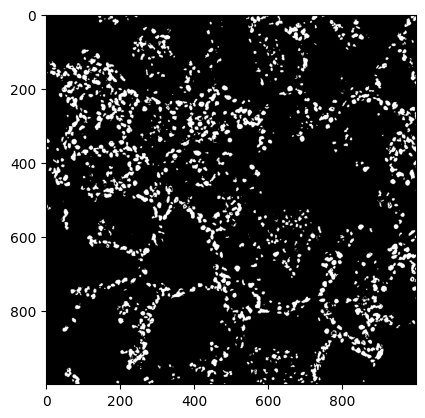

In [72]:
# Thresholding
small_thresh = filters.threshold_otsu(tophat_image)
smalldapi_binary = tophat_image > small_thresh

plt.imshow(smalldapi_binary,cmap='gray')

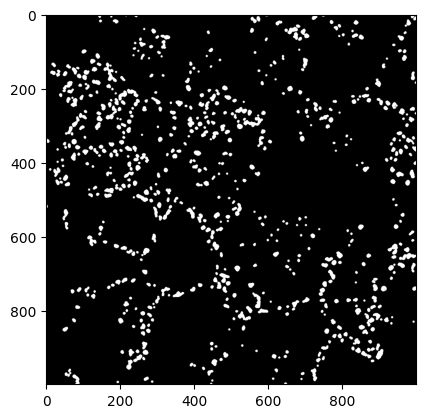

In [73]:
#open
smalldapi_open = morphology.binary_opening(smalldapi_binary, morphology.disk(3))
plt.imshow(smalldapi_open,cmap='gray')

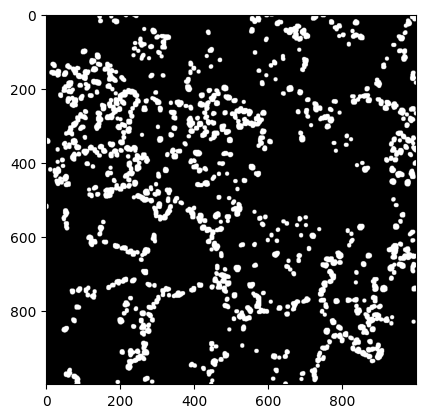

In [77]:
# dilation
dilation = morphology.binary_dilation(smalldapi_open,footprint=np.ones((5, 5)))
plt.imshow(dilation,cmap='gray')

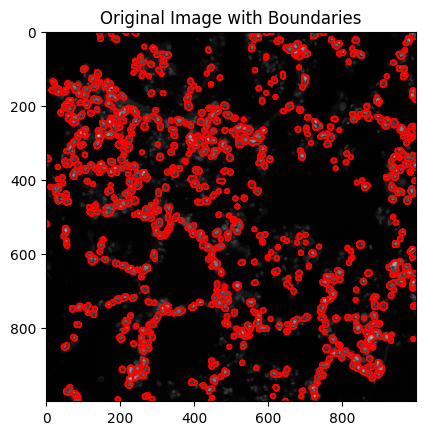

In [78]:
distance = ndi.distance_transform_edt(dilation)
coords = peak_local_max(distance, footprint=np.ones((15, 15)), labels=dilation)
dist_mask = np.zeros(distance.shape, dtype=bool)
dist_mask[tuple(coords.T)] = True
markers, _ = ndi.label(dist_mask)

# Watershed segmentation
small_labels = watershed(-distance, markers, mask=dilation)

# Find boundaries of watershed elements
small_boundaries = find_boundaries(small_labels)

# Display segmentation over original image
plt.imshow(roi_dapi, cmap='gray')
plt.contour(small_boundaries, colors='r', linewidths=0.5)
plt.title('Original Image with Boundaries')
#plt.axis('off')
plt.show()

# Feature Extraction

In [79]:
def compute_features(labels, roi):
    # Initialize lists to store feature values
    mean_intensities = []
    variances = []
    min_intensities = []
    max_intensities = []

    # Iterate over each labeled region
    for label in range(1, labels.max() + 1):  # Iterate over each label excluding background
        # Mask out the region in the original image
        region_mask = labels == label
        region_pixels = roi[region_mask]

        # Compute mean intensity of the region
        mean_intensity = np.mean(region_pixels)

        # Compute variance of intensity in the region
        variance = np.var(region_pixels)

        # Compute minimum intensity in the region
        min_intensity = np.min(region_pixels)

        # Compute maximum intensity in the region
        max_intensity = np.max(region_pixels)

        # Append computed values to respective lists
        mean_intensities.append(mean_intensity)
        variances.append(variance)
        min_intensities.append(min_intensity)
        max_intensities.append(max_intensity)

    # Stack the lists into a 2D array with four columns
    feature_array = np.column_stack((mean_intensities, variances, min_intensities, max_intensities))
    return feature_array

In [80]:
with tifffile.TiffFile(cod_path) as tif:
    feature_list = []
    for i in range(35): # 35 channels total
        print(f'channel {i}')
        channel = tif.pages[i].asarray()
        channel = cv2.copyMakeBorder(channel, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        roi_channel = channel[min_x:max_x,min_y:max_y]
        feature_channel = compute_features(small_labels, roi_channel)
        feature_list.append(feature_channel)

channel 0
channel 1
channel 2
channel 3
channel 4
channel 5
channel 6
channel 7
channel 8
channel 9
channel 10
channel 11
channel 12
channel 13
channel 14
channel 15
channel 16
channel 17
channel 18
channel 19
channel 20
channel 21
channel 22
channel 23
channel 24
channel 25
channel 26
channel 27
channel 28
channel 29
channel 30
channel 31
channel 32
channel 33
channel 34


In [217]:
feature = np.hstack(feature_list)

In [218]:
print(feature.shape)

(736, 140)


In [258]:
# min max normalization
scaler = MinMaxScaler()
normalized_feature = scaler.fit_transform(feature)

In [259]:
np.save('feature.npy',normalized_feature)

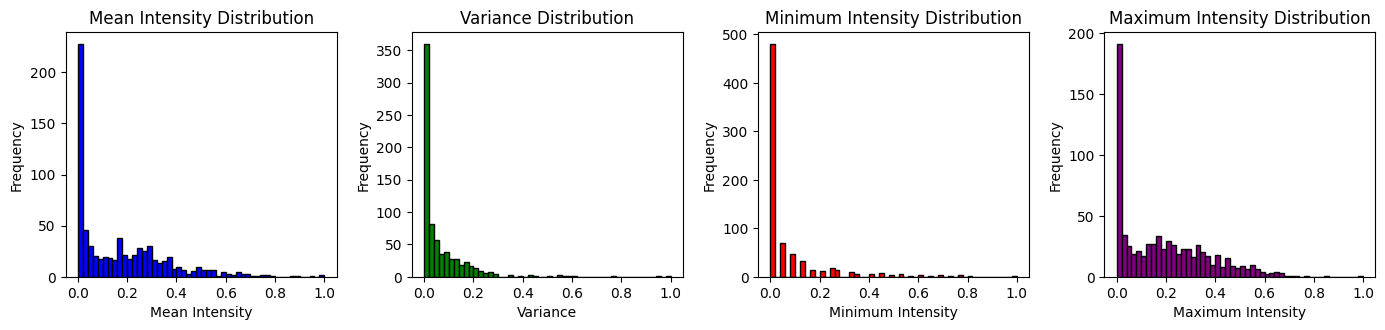

In [260]:
# Plot histograms of the extracted features
plt.figure(figsize=(14, 6))

plt.subplot(2, 4, 1)
plt.hist(normalized_feature[:,8], bins=50, color='blue', edgecolor='black')
plt.title('Mean Intensity Distribution')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 4, 2)
plt.hist(normalized_feature[:,9], bins=50, color='green', edgecolor='black')
plt.title('Variance Distribution')
plt.xlabel('Variance')
plt.ylabel('Frequency')

plt.subplot(2, 4, 3)
plt.hist(normalized_feature[:,10], bins=50, color='red', edgecolor='black')
plt.title('Minimum Intensity Distribution')
plt.xlabel('Minimum Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 4, 4)
plt.hist(normalized_feature[:,11], bins=50, color='purple', edgecolor='black')
plt.title('Maximum Intensity Distribution')
plt.xlabel('Maximum Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Clustering

In [272]:
# create anndata
feature = np.load('feature.npy')
adata = anndata.AnnData(feature)
#adata = sc.read('feature.h5ad')

In [273]:
sc.pp.pca(adata,n_comps=20)

In [274]:
sc.pp.neighbors(adata)

In [275]:
sc.tl.umap(adata)

In [276]:
sc.tl.leiden(adata,resolution=0.5,flavor = 'igraph') # higher resolution, more clusters

In [310]:
clusters_colors = dict(zip([str(i) for i in range(102)], sc.pl.palettes.default_102))
clusters_colors.pop('2') # delete pink
clusters_colors = {str(i): clusters_colors[key] for i, key in enumerate(sorted(clusters_colors.keys(), key=int))}
colorlist=adata.obs['leiden'].cat.categories.tolist()
n_cluster=str(len(colorlist))
palette=[v for k, v in clusters_colors.items() if k in colorlist]

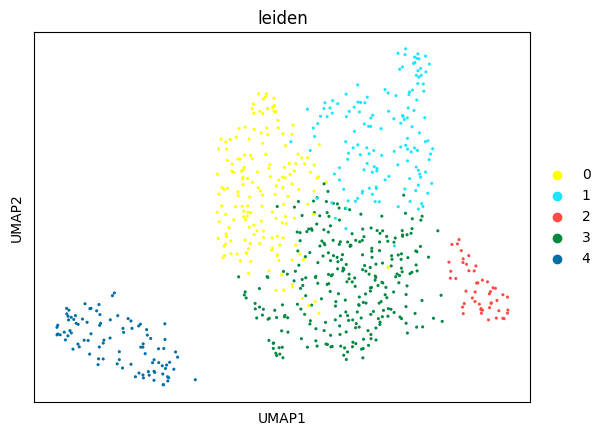

In [311]:
sc.pl.umap(
    adata, 
    color=['leiden'], 
    palette=palette,
    size=20
)

In [312]:
adata.write('cluster.h5ad')

# Map back to H&E

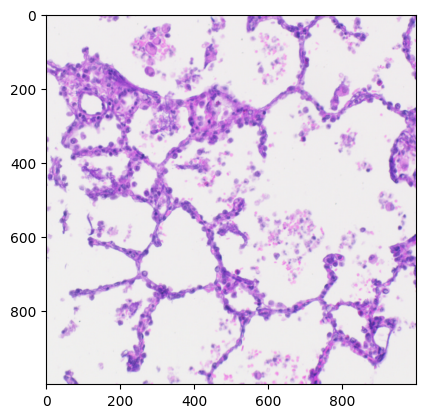

In [313]:
plt.imshow(roi_he)

In [314]:
adata = sc.read('cluster.h5ad')

In [315]:
cluster = adata.obs['leiden']

In [316]:
label_cluster_map_dict = {int(index)+1: int(value)+1 for index, value in adata.obs['leiden'].items()}

In [317]:
def map_label_to_cluster(label, map_dict):
    result = label.copy()
    for i in range(label.shape[0]):
        for j in range(label.shape[1]):
            if label[i][j] in map_dict:
                result[i][j] = map_dict[label[i][j]]
    return result

In [318]:
cluster_mask = map_label_to_cluster(small_labels,label_cluster_map_dict)

In [319]:
color_dict = {int(k): v for k, v in clusters_colors.items()}
color_dict_rgb = {k+1: tuple(int(v[i:i+2], 16) for i in (1, 3, 5)) for k, v in color_dict.items()}

In [320]:
roi_he_map = roi_he.copy()

In [321]:
for i in range(roi_he_map.shape[0]):
    for j in range(roi_he_map.shape[1]):
        cluster = cluster_mask[i][j]
        if cluster in color_dict_rgb:
            roi_he_map[i][j] = color_dict_rgb[cluster]

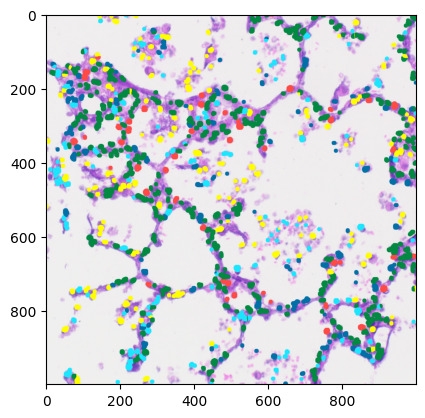

In [322]:
plt.imshow(roi_he_map)